In [1]:
import re
from tweet import Tweet
file =  open('datasets/dev.txt', 'r')
dataset = file.read()
splitted_data = re.split("[\n|\t]", dataset)
prepared_data = [splitted_data[i: i + 4] for i in range(0, len(splitted_data), 4)]
prepared_data.pop(0)
prepared_data.pop()

data =  list(map(lambda x: Tweet(x[0], x[1], x[2], int(x[3].split(":")[0]), x[3].split(":")[1]), prepared_data))

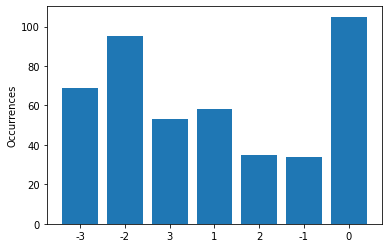

In [2]:
import numpy as np
import matplotlib.pyplot as plt

classes = {}
for t in data:
    classes[t.intensity] =  classes.get(t.intensity, 0) + 1

objects = classes.keys()
y_pos = np.arange(len(objects))
values = classes.values()

plt.bar(y_pos, values)
plt.xticks(y_pos, objects)
plt.ylabel('Occurrences')
plt.show()

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = map(lambda x: x.tweet, data)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(corpus)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
tfidf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
tfidf_df.sort_values(by=["tfidf"],ascending=False)

,tfidf
simoncalder,0.253314
crashes,0.253314
site,0.253314
hang,0.253314
ryanair,0.253314
...,...
free,0.000000
freedom,0.000000
fresh,0.000000
fridge,0.000000


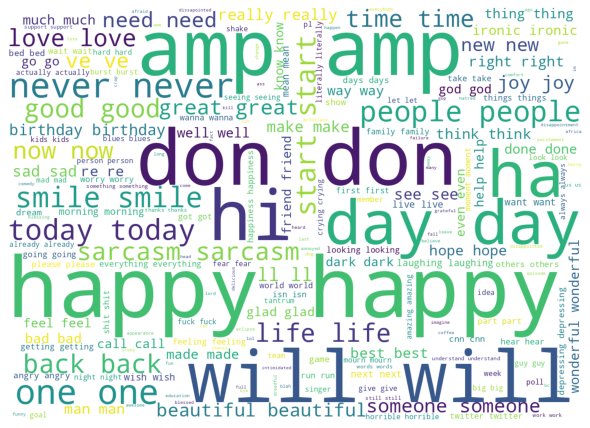

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

corpus = map(lambda x: x.tweet, data)
count_vectorizer = CountVectorizer()
count_vectorizer_vectors = count_vectorizer.fit_transform(corpus)
word_count = count_vectorizer_vectors.sum(axis=0).tolist()[0]

features = count_vectorizer.get_feature_names()
cloud_words = ""
for i in range(0, len(word_count)):
    for _ in range(0, word_count[i]):
        cloud_words += " " + features[i] + " "

wordcloud = WordCloud(width=1280, height=920, background_color='white').generate(cloud_words)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()